<a href="https://colab.research.google.com/github/jeongKihwan/NLTK/blob/main/Spam_Classifier(Bert).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# tensorflow_text 호환

!pip install tensorflow_text==2.15.0

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

In [ ]:
df = pd.read_csv('/content/spam.csv', encoding = 'ISO-8859-1')

In [ ]:
df.columns

In [ ]:
# 컬럼 삭제, 컬럼명 변경
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df.rename(columns={'v1':'Category', 'v2':'Message'},inplace=True)

In [ ]:
df.info()

In [ ]:
df.shape

In [ ]:
df.groupby('Category').describe()

In [ ]:
print('불균형 데이터: %', 747/4825)

In [ ]:
# 불균형 데이터 핸들링

df_spam = df[df['Category']=='spam']
df_spam.shape

In [ ]:
df_ham = df[df['Category']=='ham']
df_ham.shape

In [ ]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

In [ ]:
df_spam.shape[0]

In [ ]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

In [ ]:
df_balanced['Category'].value_counts()

In [ ]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

In [ ]:
df['spam'] = df['Category'].apply(lambda x:1 if x=='spam' else 0)
df.head()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify = df_balanced['spam'])

In [ ]:
X_train.head()

In [ ]:
from tensorflow.keras import layers

In [ ]:
# Bert Model
# Bert_preprocess : 원시 텍스트를 인코더에서 예상하는 숫자입력 텐서로 변경.
# Bert_encoder : 변환기 모델의 인코더 스택을 사용하여 주어진 입력의 각 토큰 표현을 출력.

bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
def get_sentence_embeding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
c = get_sentence_embeding(['mango','banana','Narendra modi','data analytics','natural language processing'])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([c[0]],[c[1]])

In [ ]:
cosine_similarity([c[3]],[c[4]])

In [ ]:
cosine_similarity([c[1]],[c[2]])

In [ ]:
# Model Building

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid',name='output')(l)

model = tf.keras.Model(inputs=[text_input],outputs=[l])

In [ ]:
model.summary()

In [ ]:
len(X_train)

In [ ]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=METRICS)

In [ ]:
# Training Model

model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 22s 335ms/step - loss: 0.5869 - accuracy: 0.7250 - precision: 0.7195 - recall: 0.7375
Epoch 2/10
35/35 [==============================] - 13s 377ms/step - loss: 0.4678 - accuracy: 0.8518 - precision: 0.8283 - recall: 0.8875
Epoch 3/10
35/35 [==============================] - 12s 352ms/step - loss: 0.4032 - accuracy: 0.8741 - precision: 0.8775 - recall: 0.8696
Epoch 4/10
35/35 [==============================] - 12s 332ms/step - loss: 0.3708 - accuracy: 0.8723 - precision: 0.8743 - recall: 0.8696
Epoch 5/10
35/35 [==============================] - 12s 341ms/step - loss: 0.3359 - accuracy: 0.8982 - precision: 0.8780 - recall: 0.9250
Epoch 6/10
35/35 [==============================] - 12s 351ms/step - loss: 0.3178 - accuracy: 0.8973 - precision: 0.8952 - recall: 0.9000
Epoch 7/10
35/35 [==============================] - 12s 357ms/step - loss: 0.3002 - accuracy: 0.9089 - precision: 0.9032 - recall: 0.9161
Epoch 8/10
35/35 [================

In [ ]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 341ms/step - loss: 0.2710 - accuracy: 0.9011 - precision: 0.9261 - recall: 0.8717


[0.27104151248931885,
 0.9010695219039917,
 0.9261363744735718,
 0.8716577291488647]

In [ ]:
# Testing the model

y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 4s 331ms/step


In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
cm

array([[174,  13],
       [ 24, 163]])

Text(50.722222222222214, 0.5, 'Truth')

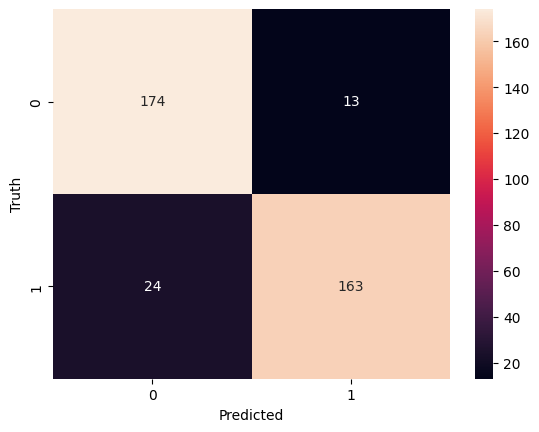

In [ ]:
# Heatmap

import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
# Classification Report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       187
           1       0.93      0.87      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



In [77]:
# Testing on Random input

reviews = [
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."]

model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.8631462 ],
       [0.8064769 ],
       [0.7933491 ],
       [0.25947446],
       [0.143308  ]], dtype=float32)

In [ ]:
### 위의 예제에서 처음 세 개의 메일은 스팸이고, 다른 두개는 스팸이 아니라고 결론